In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, roc_auc_score
from tqdm import tqdm

# Load the dataset
file_path = '../The_Hofmarcher_Files/CP_count_Hofmarcher.csv'  
data = pd.read_csv(file_path)

# List of assay columns to process (assuming all columns except INCHIKEY and the last 13 columns are assays)
assay_columns = data.columns[1:-13]

# Initialize a list to store results
results = []

# Define a function to calculate a probability score based on the distance from the threshold
def calculate_probability_score(value, threshold):
    return 1 / (1 + np.exp(value - threshold))

# Define threshold range based on the dataset
min_value = data['Cells_Number_Object_Number'].min()
max_value = data['Cells_Number_Object_Number'].max()
thresholds = np.arange(min_value, max_value, 1)

# Process each assay and each threshold
for assay in tqdm(assay_columns):
    # Drop rows with NaNs or -1s in the current assay column or in Cells_Number_Object_Number
    valid_data = data[(data[assay] != -1) & (data[assay].notna())].copy().reset_index(drop=True)

    # Process for each threshold
    for threshold in thresholds:
    
        # Calculate the probability score
        valid_data.loc[:, 'Probability_Score'] = valid_data['Cells_Number_Object_Number'].apply(calculate_probability_score, threshold=threshold)
        # print(valid_data[['Probability_Score']])
        # True values for the assay
        true_values = valid_data[assay] == 1
        predicted_probs = valid_data['Probability_Score']
        predicted_values = valid_data['Probability_Score'] >= 0.5

        # Calculate TP, FP, TN, FN
        TP = np.sum((predicted_values == 1) & (true_values == 1))
        FP = np.sum((predicted_values == 1) & (true_values == 0))
        TN = np.sum((predicted_values == 0) & (true_values == 0))
        FN = np.sum((predicted_values == 0) & (true_values == 1))

        # Calculate metrics
        accuracy = accuracy_score(true_values, predicted_values)
        balanced_accuracy = balanced_accuracy_score(true_values, predicted_values)
        recall = recall_score(true_values, predicted_values, zero_division=0)
        precision = precision_score(true_values, predicted_values, zero_division=0)
        auc = roc_auc_score(true_values, predicted_probs)
        # print(auc)

        # Append the result
        results.append({
            'Assay': assay,
            'Accuracy': accuracy,
            'Balanced Accuracy': balanced_accuracy,
            'Recall': recall,
            'Precision': precision,
            'Threshold': threshold,
            'AUC': auc,
            'TP': TP,
            'FP': FP,
            'TN': TN,
            'FN': FN
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save the results to a CSV file
results_df.to_csv('assay_auc_by_threshold_with_confusion_Hofmarcher.csv', index=False)


100%|██████████| 209/209 [01:29<00:00,  2.34it/s]


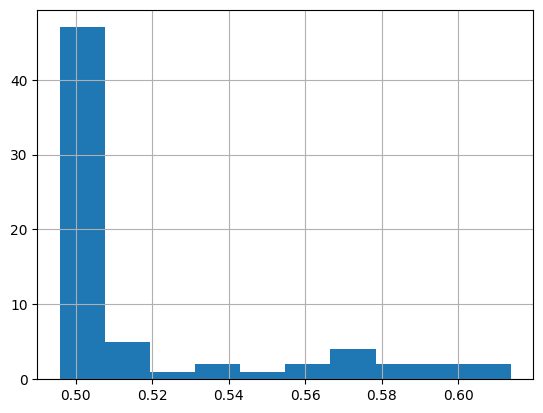

In [2]:
results_df = pd.read_csv('assay_auc_by_threshold_with_confusion_Hofmarcher.csv')

results_df["Threshold"] = results_df["Threshold"].round(2)

results_df[results_df["Assay"]==31]["Balanced Accuracy"].hist()
plt.show()

/tmp/ipykernel_41296/1900095971.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  threshold_counts = results_df.groupby('Threshold').apply(lambda x: (x['Balanced Accuracy'] > 0.50).sum()).reset_index(name='Assays with BA > 0.50')


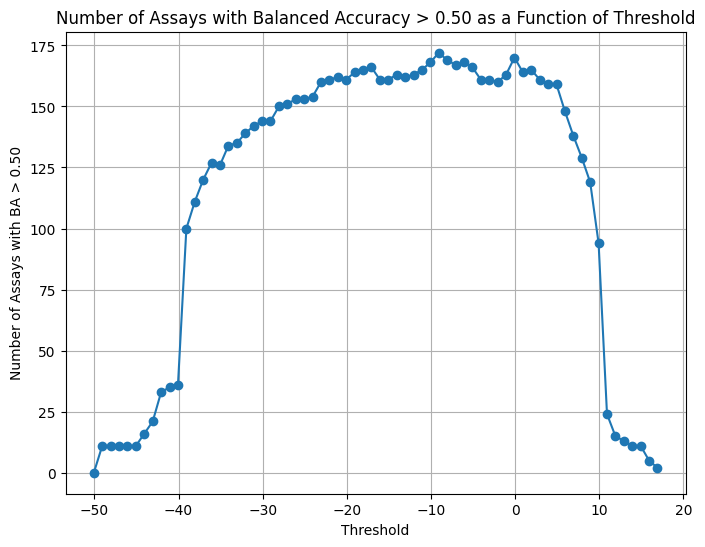

In [39]:
# Group by threshold and count how many assays have balanced accuracy > 0.50 at each threshold
threshold_counts = results_df.groupby('Threshold').apply(lambda x: (x['Balanced Accuracy'] > 0.50).sum()).reset_index(name='Assays with BA > 0.50')

# Plot the result
plt.figure(figsize=(8, 6))
plt.plot(threshold_counts['Threshold'], threshold_counts['Assays with BA > 0.50'], marker='o', linestyle='-')
plt.title('Number of Assays with Balanced Accuracy > 0.50 as a Function of Threshold')
plt.xlabel('Threshold')
plt.ylabel('Number of Assays with BA > 0.50')
plt.grid(True)
plt.show()

/tmp/ipykernel_41296/434161599.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  threshold_counts = results_df.groupby('Threshold').apply(lambda x: (x['Balanced Accuracy'] > 0.60).sum()).reset_index(name='Assays with BA > 0.60')


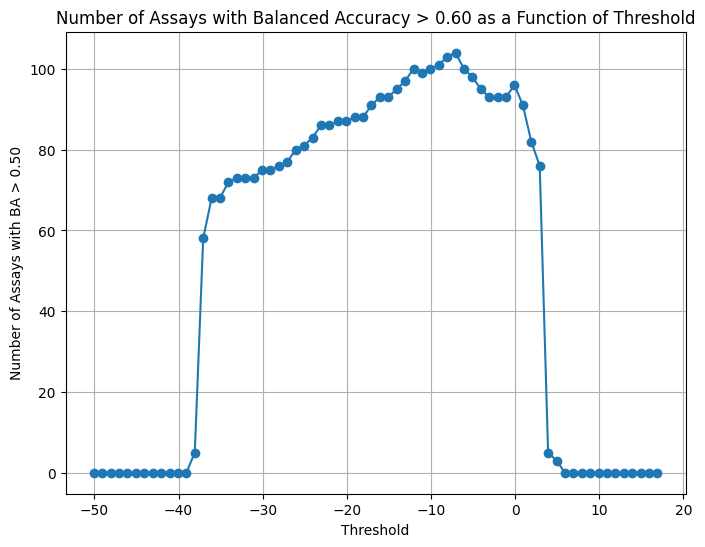

In [40]:
# Group by threshold and count how many assays have balanced accuracy > 0.50 at each threshold
threshold_counts = results_df.groupby('Threshold').apply(lambda x: (x['Balanced Accuracy'] > 0.60).sum()).reset_index(name='Assays with BA > 0.60')

# Plot the result
plt.figure(figsize=(8, 6))
plt.plot(threshold_counts['Threshold'], threshold_counts['Assays with BA > 0.60'], marker='o', linestyle='-')
plt.title('Number of Assays with Balanced Accuracy > 0.60 as a Function of Threshold')
plt.xlabel('Threshold')
plt.ylabel('Number of Assays with BA > 0.50')
plt.grid(True)
plt.show()


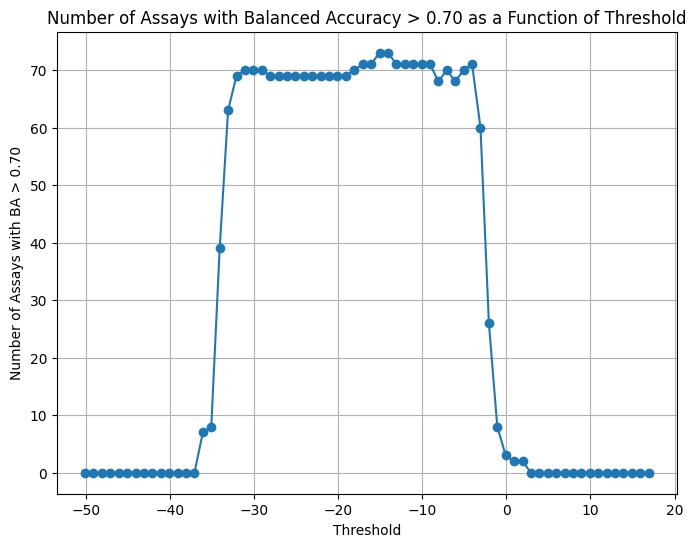

In [3]:
# Group by threshold and count how many assays have balanced accuracy > 0.50 at each threshold
threshold_counts = results_df.groupby('Threshold').apply(lambda x: (x['Balanced Accuracy'] > 0.70).sum()).reset_index(name='Assays with BA > 0.70')

# Plot the result
plt.figure(figsize=(8, 6))
plt.plot(threshold_counts['Threshold'], threshold_counts['Assays with BA > 0.70'], marker='o', linestyle='-')
plt.title('Number of Assays with Balanced Accuracy > 0.70 as a Function of Threshold')
plt.xlabel('Threshold')
plt.ylabel('Number of Assays with BA > 0.70')
plt.grid(True)
plt.show()


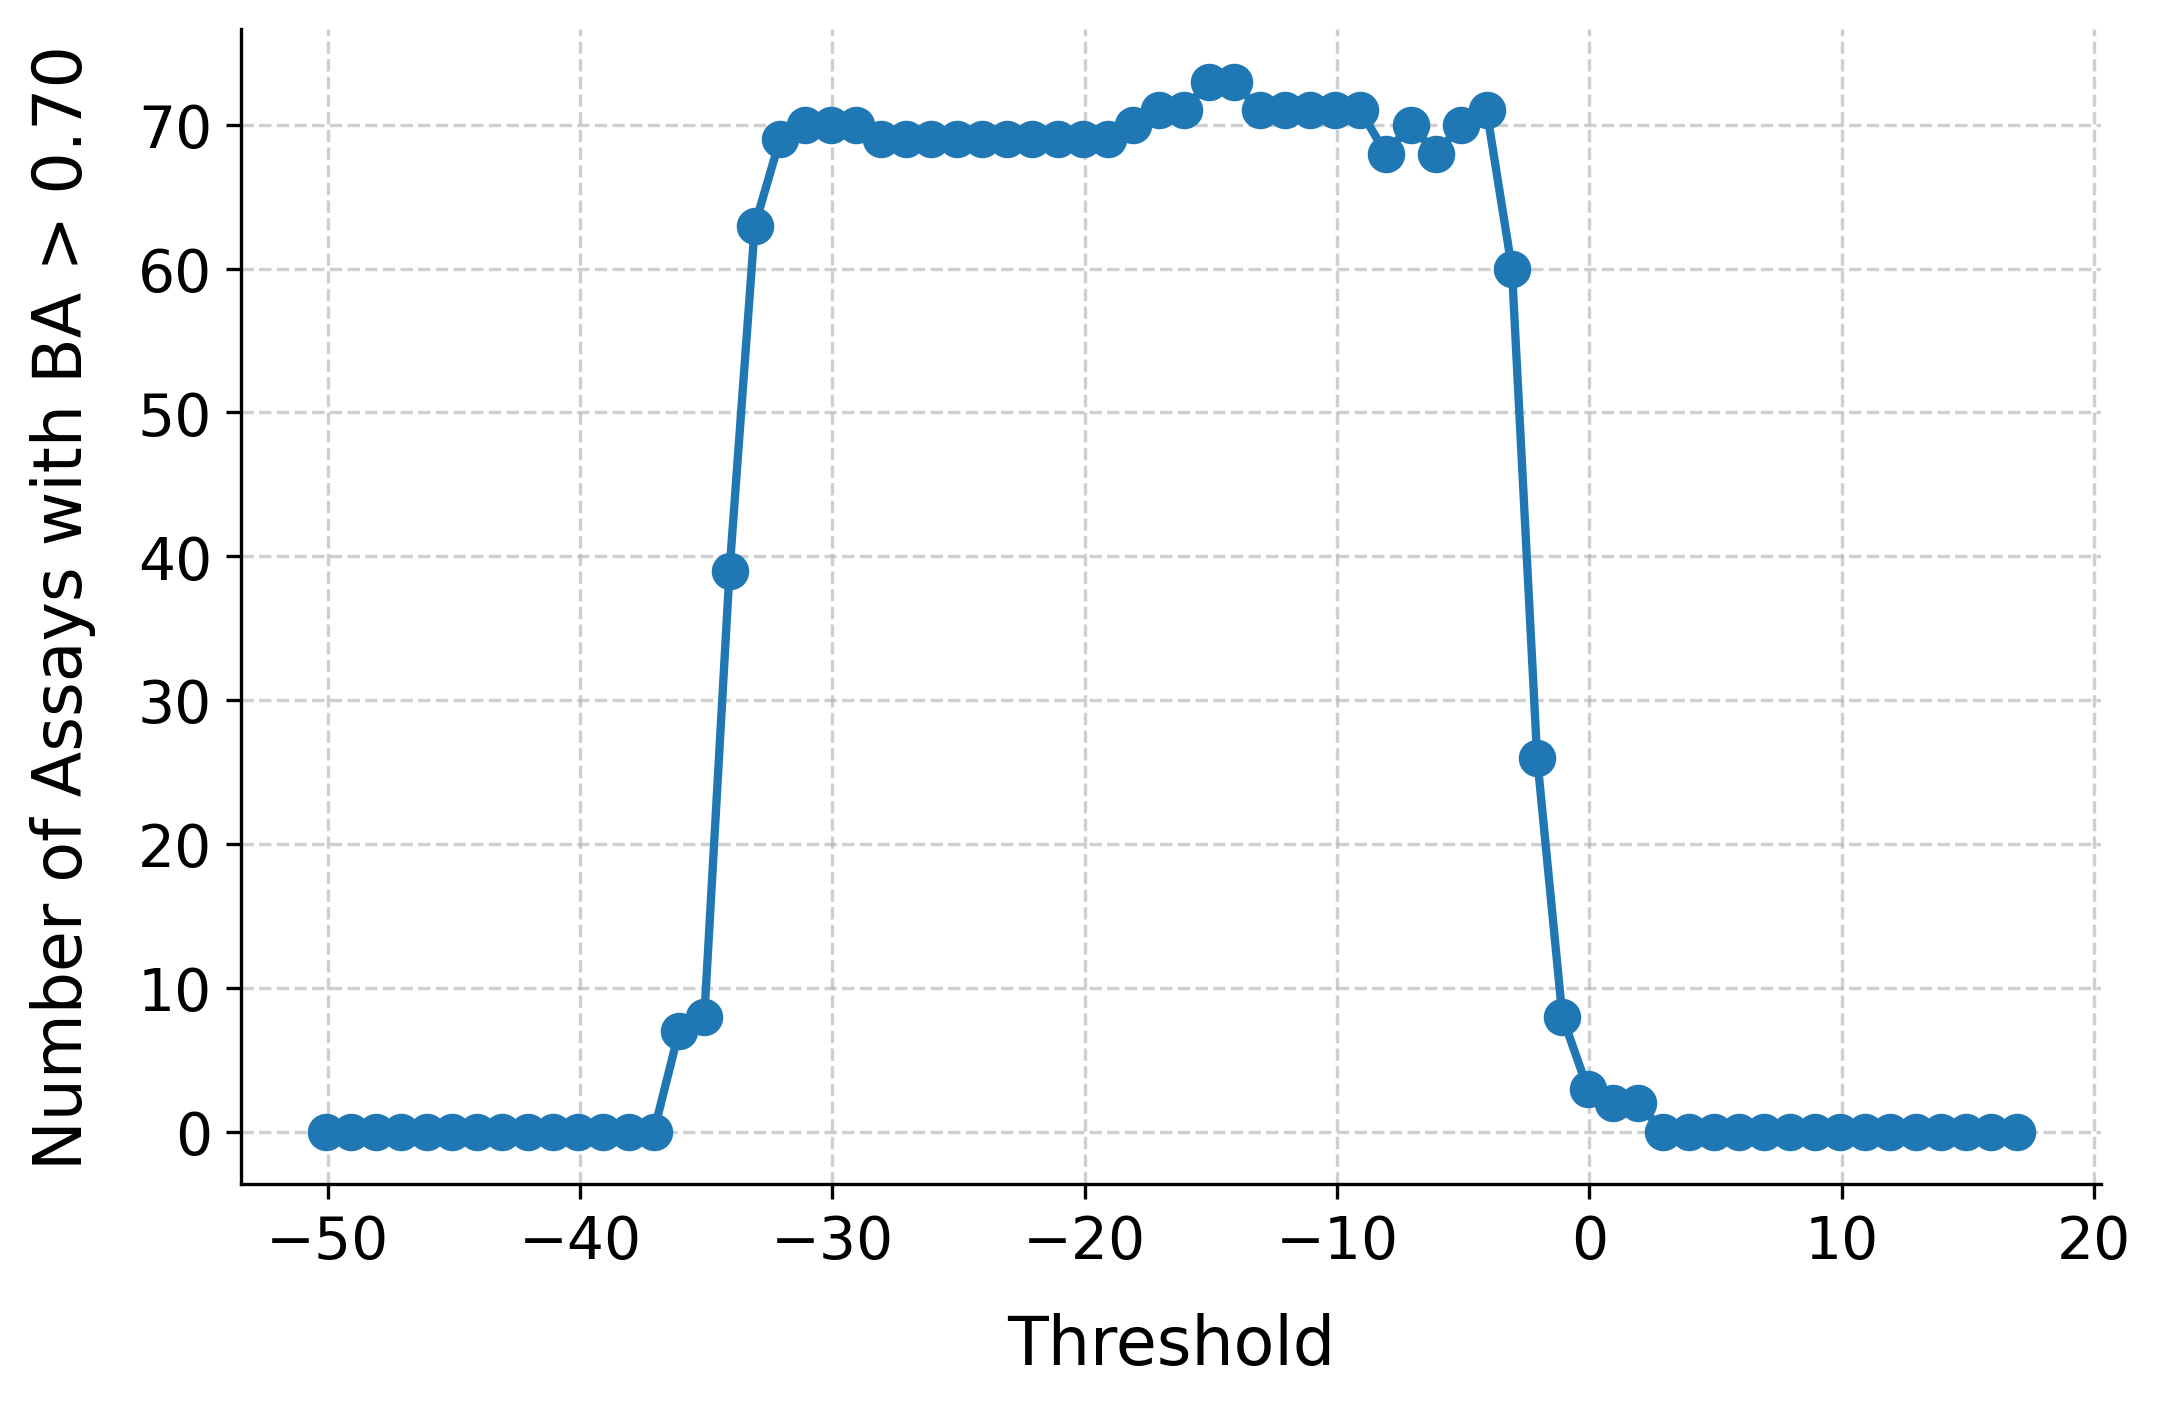

In [4]:


# Group by threshold and count how many assays have balanced accuracy > 0.70
threshold_counts = (
    results_df.groupby("Threshold")
    .apply(lambda x: (x["Balanced Accuracy"] > 0.70).sum())
    .reset_index(name="Assays with BA > 0.70")
)

# Plot the refined result
plt.figure(figsize=(8, 5), dpi=300)

plt.plot(
    threshold_counts["Threshold"],
    threshold_counts["Assays with BA > 0.70"],
    marker="o",
    linestyle="-",
    markersize=8,
    linewidth=2,
)

# Customizing plot aesthetics
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Labels with refined font sizes and padding
plt.xlabel("Threshold", fontsize=16, labelpad=10)
plt.ylabel("Number of Assays with BA > 0.70", fontsize=16, labelpad=10)

# Adjusting tick parameters for improved readability
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Title with improved readability
#plt.title("Assays with Balanced Accuracy > 0.70 vs Threshold", fontsize=16, pad=10)

# Grid for better visualization
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()


/tmp/ipykernel_41296/2273959624.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  threshold_counts = results_df.groupby('Threshold').apply(lambda x: (x['AUC'] > 0.7).sum()).reset_index(name='Assays with AUC>')


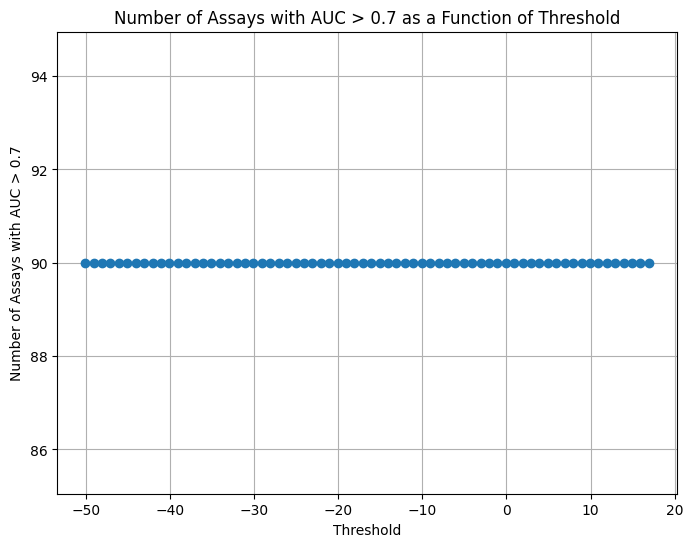

In [42]:
# Group by threshold and count how many assays have balanced accuracy > 0.50 at each threshold
threshold_counts = results_df.groupby('Threshold').apply(lambda x: (x['AUC'] > 0.7).sum()).reset_index(name='Assays with AUC>')

# Plot the result
plt.figure(figsize=(8, 6))
plt.plot(threshold_counts['Threshold'], threshold_counts['Assays with AUC>'], marker='o', linestyle='-')
plt.title('Number of Assays with AUC > 0.7 as a Function of Threshold')
plt.xlabel('Threshold')
plt.ylabel('Number of Assays with AUC > 0.7')
plt.grid(True)
plt.show()


/home/jupyter-seal@broadinstitut-41f01/.conda/envs/my-rdkit-env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


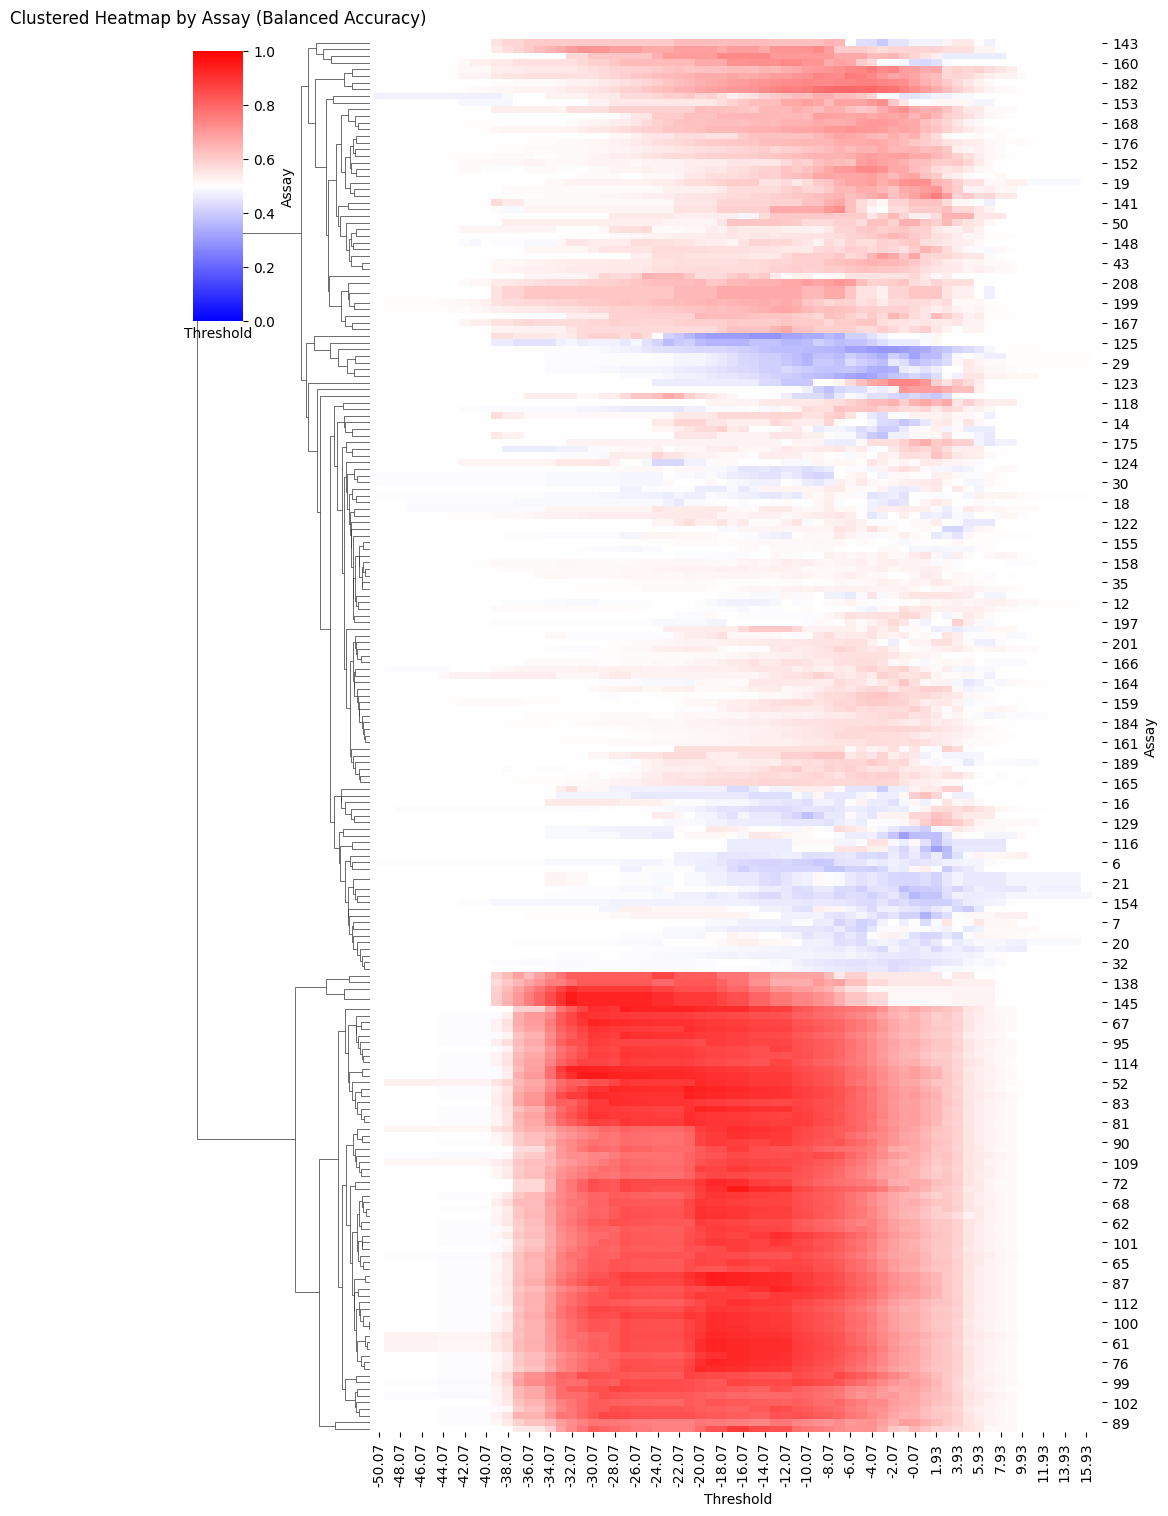

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'blue'), (0.5, 'white'), (1, 'red')])

# Create a pivot table for the heatmap, with 'Assay' as rows, 'Threshold' as columns, and 'Balanced Accuracy' as values
heatmap_data = results_df.pivot(index='Assay', columns='Threshold', values='Balanced Accuracy')

# Plot the clustered heatmap with clustering only by Assay (rows)
sns.clustermap(heatmap_data, cmap=custom_cmap, cbar=True, figsize=(10, 15), 
               row_cluster=True, col_cluster=False, dendrogram_ratio=(0.2, 0), method='average',
               center=0.5, vmin=0, vmax=1)

plt.title('Clustered Heatmap by Assay (Balanced Accuracy)', pad=20)
plt.xlabel('Threshold')
plt.ylabel('Assay')
plt.show()


/home/jupyter-seal@broadinstitut-41f01/.conda/envs/my-rdkit-env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


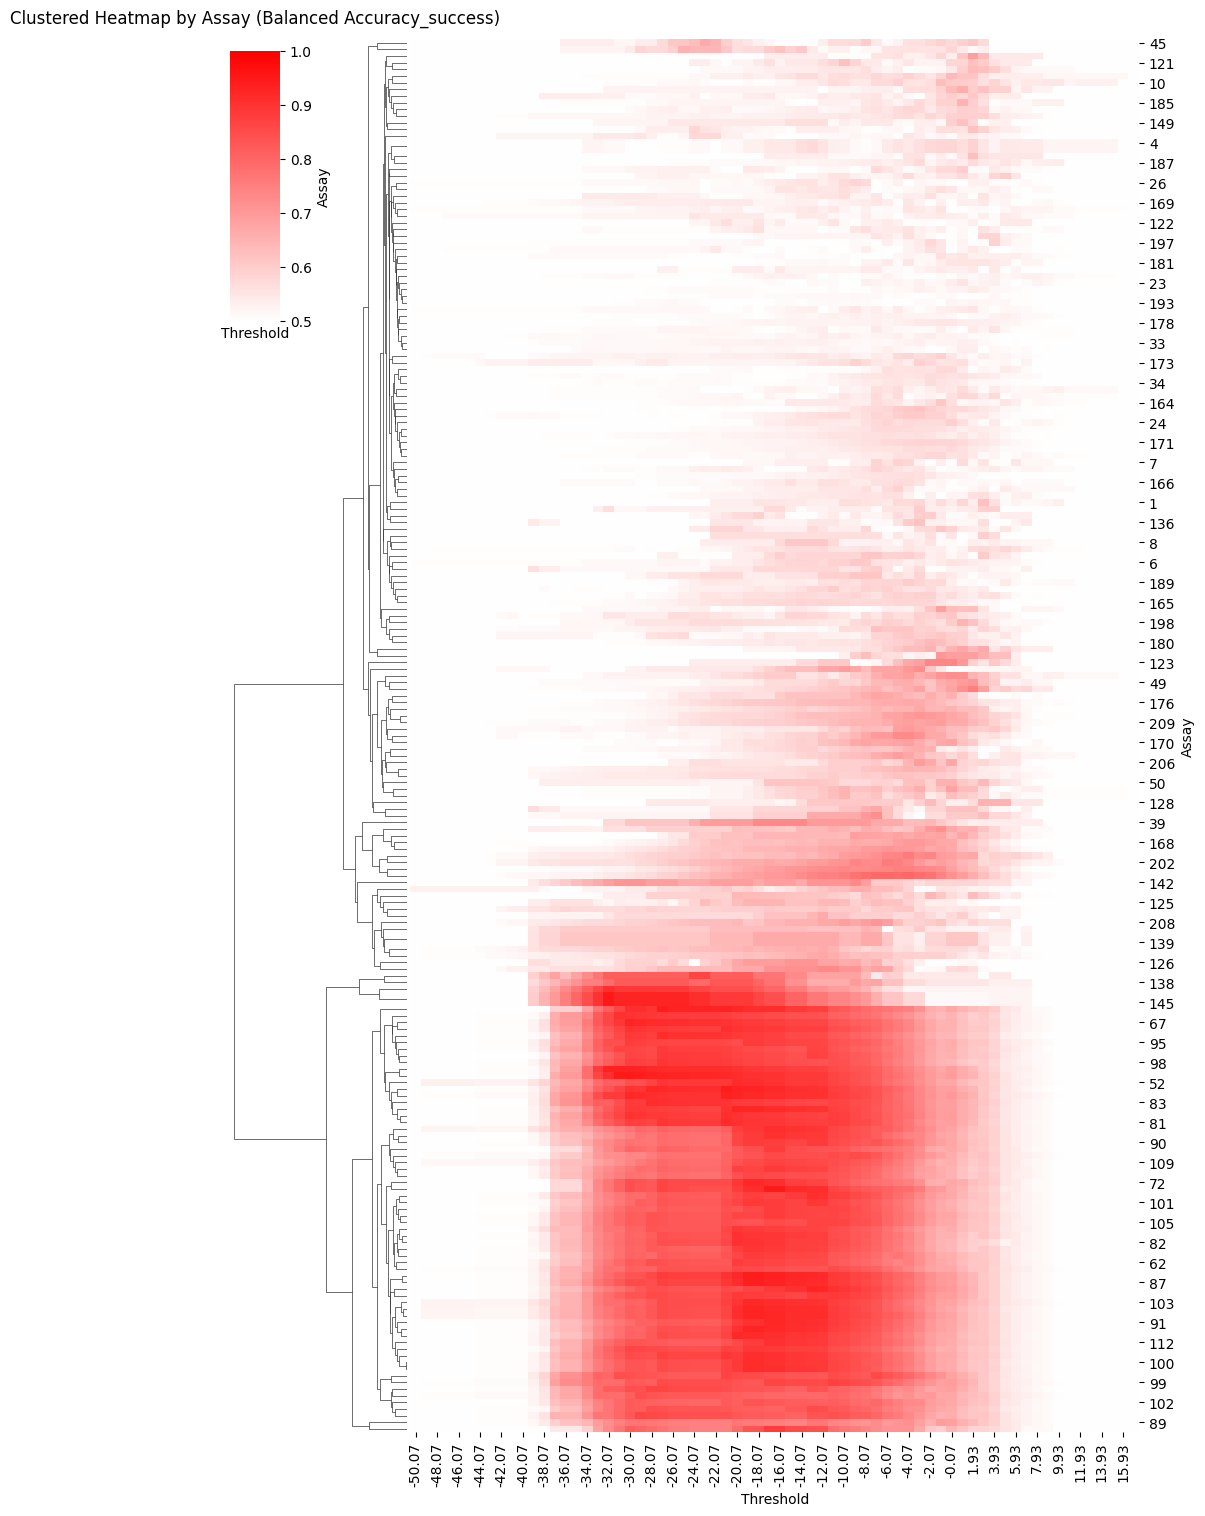

In [44]:
results_df["Balanced Accuracy_success"] = results_df["Balanced Accuracy"].apply(lambda x: 1 - x if x < 0.5 else x)
results_df["AUC_success"] = results_df["AUC"].apply(lambda x: 1 - x if x < 0.5 else x)


custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'blue'), (0.5, 'white'), (1, 'red')])

# Create a pivot table for the heatmap, with 'Assay' as rows, 'Threshold' as columns, and 'Balanced Accuracy' as values
heatmap_data = results_df.pivot(index='Assay', columns='Threshold', values='Balanced Accuracy_success')

# Plot the clustered heatmap with clustering only by Assay (rows)
sns.clustermap(heatmap_data, cmap=custom_cmap, cbar=True, figsize=(10, 15), 
               row_cluster=True, col_cluster=False, dendrogram_ratio=(0.2, 0), method='average',
               center=0.5, vmin=0.5, vmax=1)

plt.title('Clustered Heatmap by Assay (Balanced Accuracy_success)', pad=20)
plt.xlabel('Threshold')
plt.ylabel('Assay')
plt.show()


In [45]:
results_df

,Assay,Accuracy,Balanced Accuracy,Recall,Precision,Threshold,AUC,TP,FP,TN,FN,Balanced Accuracy_success,AUC_success
0,1,0.131148,0.5,0.0,0.000000,-50.07,0.393278,0,0,16,106,0.5,0.606722
1,1,0.131148,0.5,0.0,0.000000,-49.07,0.393278,0,0,16,106,0.5,0.606722
2,1,0.131148,0.5,0.0,0.000000,-48.07,0.393278,0,0,16,106,0.5,0.606722
3,1,0.131148,0.5,0.0,0.000000,-47.07,0.393278,0,0,16,106,0.5,0.606722
4,1,0.131148,0.5,0.0,0.000000,-46.07,0.393278,0,0,16,106,0.5,0.606722
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207,209,0.143501,0.5,1.0,0.143501,12.93,0.759884,223,1331,0,0,0.5,0.759884
14208,209,0.143501,0.5,1.0,0.143501,13.93,0.759968,223,1331,0,0,0.5,0.759968
14209,209,0.143501,0.5,1.0,0.143501,14.93,0.759898,223,1331,0,0,0.5,0.759898
14210,209,0.143501,0.5,1.0,0.143501,15.93,0.759884,223,1331,0,0,0.5,0.759884


In [46]:
import pandas as pd


target_map =  pd.read_csv("../The_Hofmarcher_Files/data/column-assay-index.csv")
target_map = target_map.reset_index()
target_map["index"] = target_map["index"] +1
target_map

,index,ASSAY_ID,CHEMBL_ID
0,1,600885,CHEMBL1040691
1,2,688422,CHEMBL1614544
2,3,688493,CHEMBL1613914
3,4,688810,CHEMBL1613836
4,5,688812,CHEMBL1613838
...,...,...,...
204,205,1301866,CHEMBL3214913
205,206,1301890,CHEMBL3214967
206,207,1301859,CHEMBL3214906
207,208,1301893,CHEMBL3214970


In [47]:
results_df = pd.merge(results_df, target_map, left_on="Assay", right_on="index")
results_df

,Assay,Accuracy,Balanced Accuracy,Recall,Precision,Threshold,AUC,TP,FP,TN,FN,Balanced Accuracy_success,AUC_success,index,ASSAY_ID,CHEMBL_ID
0,1,0.131148,0.5,0.0,0.000000,-50.07,0.393278,0,0,16,106,0.5,0.606722,1,600885,CHEMBL1040691
1,1,0.131148,0.5,0.0,0.000000,-49.07,0.393278,0,0,16,106,0.5,0.606722,1,600885,CHEMBL1040691
2,1,0.131148,0.5,0.0,0.000000,-48.07,0.393278,0,0,16,106,0.5,0.606722,1,600885,CHEMBL1040691
3,1,0.131148,0.5,0.0,0.000000,-47.07,0.393278,0,0,16,106,0.5,0.606722,1,600885,CHEMBL1040691
4,1,0.131148,0.5,0.0,0.000000,-46.07,0.393278,0,0,16,106,0.5,0.606722,1,600885,CHEMBL1040691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207,209,0.143501,0.5,1.0,0.143501,12.93,0.759884,223,1331,0,0,0.5,0.759884,209,1495346,CHEMBL3562077
14208,209,0.143501,0.5,1.0,0.143501,13.93,0.759968,223,1331,0,0,0.5,0.759968,209,1495346,CHEMBL3562077
14209,209,0.143501,0.5,1.0,0.143501,14.93,0.759898,223,1331,0,0,0.5,0.759898,209,1495346,CHEMBL3562077
14210,209,0.143501,0.5,1.0,0.143501,15.93,0.759884,223,1331,0,0,0.5,0.759884,209,1495346,CHEMBL3562077


In [118]:
# Define the threshold percentage (e.g., 70%) for "most" of the thresholds
threshold_percentage = 0.4

# Group by Assay and check if more than 70% of the 'Balanced Accuracy_success' values are > 0.7
assays_with_most_ba_success = results_df.groupby('Assay').filter(lambda x: (x['Balanced Accuracy_success'] > 0.7).mean() > threshold_percentage)

# Extract the list of assays
assay_list_most = assays_with_most_ba_success['CHEMBL_ID'].unique()

# Display the list of assays
assay_list_most


array(['CHEMBL1963976', 'CHEMBL1963981', 'CHEMBL1963985', 'CHEMBL1963989',
       'CHEMBL1963990', 'CHEMBL1963991', 'CHEMBL1963994', 'CHEMBL1964017',
       'CHEMBL1964018', 'CHEMBL1964021', 'CHEMBL1964025', 'CHEMBL1964030',
       'CHEMBL1964034', 'CHEMBL1964037', 'CHEMBL1964040', 'CHEMBL1964043',
       'CHEMBL1964045', 'CHEMBL1964047', 'CHEMBL1964048', 'CHEMBL1964059',
       'CHEMBL1964062', 'CHEMBL1964063', 'CHEMBL1964065', 'CHEMBL1964066',
       'CHEMBL1964072', 'CHEMBL1964075', 'CHEMBL1964077', 'CHEMBL1964085',
       'CHEMBL1964086', 'CHEMBL1964087', 'CHEMBL1964088', 'CHEMBL1964091',
       'CHEMBL1964092', 'CHEMBL1964099', 'CHEMBL1963844', 'CHEMBL1963854',
       'CHEMBL1963860', 'CHEMBL1963866', 'CHEMBL1963868', 'CHEMBL1963874',
       'CHEMBL1963876', 'CHEMBL1963880', 'CHEMBL1963882', 'CHEMBL1963885',
       'CHEMBL1963887', 'CHEMBL1963889', 'CHEMBL1963895', 'CHEMBL1963900',
       'CHEMBL1963901', 'CHEMBL1963903', 'CHEMBL1963911', 'CHEMBL1963921',
       'CHEMBL1963922', '

In [117]:
len(assay_list_most)

196

In [5]:
import requests
import pandas as pd
from pandarallel import pandarallel

# Initialize pandarallel
pandarallel.initialize(progress_bar=True)

def get_chembl_data(chembl_id):
    url = f'https://www.ebi.ac.uk/chembl/api/data/assay/{chembl_id}'
    headers = {'Accept': 'application/json'}
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        data = response.json()
        
        assay_type = data.get('assay_type', 'Unknown')
        assay_description = data.get('description', 'Unknown')
        target_info = data.get('target_chembl_id', 'Unknown')
        
        if target_info != 'Unknown':
            target_url = f'https://www.ebi.ac.uk/chembl/api/data/target/{target_info}'
            target_response = requests.get(target_url, headers=headers)
            target_response.raise_for_status()
            target_data = target_response.json()
            
            target_type = target_data.get('target_type', 'Unknown')
            target_name = target_data.get('pref_name', 'Unknown')
            organism = target_data.get('organism', 'Unknown')
            
            # Extract gene symbol from target_components if available
            gene_symbol = 'Unknown'
            target_components = target_data.get('target_components', [])
            if target_components:
                for component in target_components:
                    if 'accession' in component and 'gene_symbol' in component:
                        gene_symbol = component.get('gene_symbol', 'Unknown')
                        break
        else:
            target_type = target_name = organism = gene_symbol = 'Unknown'
        
        return {
            'CHEMBL_ID': chembl_id,
            'Assay_Type': assay_type,
            'Assay_Description': assay_description,
            'Target_Type': target_type,
            'Target_Name': target_name,
            'Organism': organism,
            'Gene_Symbol': gene_symbol
        }
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for {chembl_id}: {e}")
        return {
            'CHEMBL_ID': chembl_id,
            'Assay_Type': 'Error',
            'Assay_Description': 'Error',
            'Target_Type': 'Error',
            'Target_Name': 'Error',
            'Organism': 'Error',
            'Gene_Symbol': 'Error'
        }
    

# Use pandarallel to apply the function in parallel
chembl_data = target_map['CHEMBL_ID'].parallel_apply(get_chembl_data)

# Convert the result to a DataFrame
chembl_data = pd.DataFrame(list(chembl_data))
chembl_data



INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


,CHEMBL_ID,Assay_Type,Assay_Description,Target_Type,Target_Name,Organism,Gene_Symbol
0,CHEMBL1040691,F,NOVARTIS: Inhibition of Plasmodium falciparum ...,ORGANISM,Plasmodium falciparum,Plasmodium falciparum,Unknown
1,CHEMBL1614544,F,PUBCHEM_BIOASSAY: qHTS Assay for Modulators of...,SINGLE PROTEIN,Prelamin-A/C,Homo sapiens,Unknown
2,CHEMBL1613914,F,PUBCHEM_BIOASSAY: qHTS Assay for Inhibitors of...,SINGLE PROTEIN,Lysine-specific demethylase 4D-like,Homo sapiens,Unknown
3,CHEMBL1613836,F,PUBCHEM_BIOASSAY: qHTS Assay for Modulators of...,NUCLEIC-ACID,microRNA 21,Homo sapiens,Unknown
4,CHEMBL1613838,F,PUBCHEM_BIOASSAY: qHTS Assay for Rab9 Promoter...,SINGLE PROTEIN,Ras-related protein Rab-9A,Homo sapiens,Unknown
...,...,...,...,...,...,...,...
204,CHEMBL3214913,B,PubChem BioAssay. qHTS for Inhibitors of bindi...,UNCHECKED,Unchecked,None,Unknown
205,CHEMBL3214967,F,PubChem BioAssay. qHTS for Antagonist of cAMP-...,SINGLE PROTEIN,Rap guanine nucleotide exchange factor 3,Homo sapiens,Unknown
206,CHEMBL3214906,F,PubChem BioAssay. qHTS for Agonist of cAMP-reg...,SINGLE PROTEIN,Rap guanine nucleotide exchange factor 4,Homo sapiens,Unknown
207,CHEMBL3214970,F,PubChem BioAssay. qHTS Assay for Identifying G...,UNCHECKED,Unchecked,None,Unknown


In [52]:
from chembl_webresource_client.new_client import new_client

# Initialize ChEMBL client
chembl_client = new_client

def get_gene_name_for_assay(assay_chembl_id):
    try:
        # Fetch assay details
        assay = chembl_client.assay
        assay_data = list(assay.filter(assay_chembl_id=assay_chembl_id).only("target_chembl_id"))
        
        if not assay_data:
            print(f"Assay ChEMBL ID {assay_chembl_id} not found in the database.")
            return None

        # Extract target_chembl_id
        target_chembl_id = assay_data[0].get("target_chembl_id")
        if not target_chembl_id:
            print(f"No target associated with assay {assay_chembl_id}.")
            return None

        # Fetch target components
        target = chembl_client.target
        target_data = list(target.filter(target_chembl_id=target_chembl_id).only("target_components"))

        if target_data and target_data[0].get("target_components"):
            # Extract gene name from target components
            target_components = target_data[0]["target_components"]
            gene_symbol = next((synonym['component_synonym']
                                for component in target_components
                                for synonym in component.get('target_component_synonyms', [])
                                if synonym['syn_type'] == 'GENE_SYMBOL'), None)
            return gene_symbol

        print(f"No gene symbol found for target {target_chembl_id}.")
        return "Unknown"

    except Exception as e:
        print(f"Error fetching gene name for assay {assay_chembl_id}: {e}")
        return "Unknown"


In [53]:
chembl_data["Gene_Symbol"] = chembl_data["CHEMBL_ID"].parallel_apply(get_gene_name_for_assay)
chembl_data

No gene symbol found for target CHEMBL612263.No gene symbol found for target CHEMBL613533.No gene symbol found for target CHEMBL390.


No gene symbol found for target CHEMBL364.No gene symbol found for target CHEMBL614576.
No gene symbol found for target CHEMBL614056.

No gene symbol found for target CHEMBL394.
No gene symbol found for target CHEMBL614642.
No gene symbol found for target CHEMBL614803.
No gene symbol found for target CHEMBL613977.
No gene symbol found for target CHEMBL612262.No gene symbol found for target CHEMBL614110.

No gene symbol found for target CHEMBL614882.No gene symbol found for target CHEMBL612545.

No gene symbol found for target CHEMBL612545.No gene symbol found for target CHEMBL612545.No gene symbol found for target CHEMBL614561.No gene symbol found for target CHEMBL612545.No gene symbol found for target CHEMBL612545.No gene symbol found for target CHEMBL614072.No gene symbol found for target CHEMBL614487.No gene symbol found for target CHEMBL612545.No ge

,CHEMBL_ID,Assay_Type,Assay_Description,Target_Type,Target_Name,Organism,Gene_Symbol
0,CHEMBL1040691,F,NOVARTIS: Inhibition of Plasmodium falciparum ...,ORGANISM,Plasmodium falciparum,Plasmodium falciparum,Unknown
1,CHEMBL1614544,F,PUBCHEM_BIOASSAY: qHTS Assay for Modulators of...,SINGLE PROTEIN,Prelamin-A/C,Homo sapiens,LMNA
2,CHEMBL1613914,F,PUBCHEM_BIOASSAY: qHTS Assay for Inhibitors of...,SINGLE PROTEIN,Lysine-specific demethylase 4D-like,Homo sapiens,KDM4E
3,CHEMBL1613836,F,PUBCHEM_BIOASSAY: qHTS Assay for Modulators of...,NUCLEIC-ACID,microRNA 21,Homo sapiens,None
4,CHEMBL1613838,F,PUBCHEM_BIOASSAY: qHTS Assay for Rab9 Promoter...,SINGLE PROTEIN,Ras-related protein Rab-9A,Homo sapiens,RAB9A
...,...,...,...,...,...,...,...
204,CHEMBL3214913,B,PubChem BioAssay. qHTS for Inhibitors of bindi...,UNCHECKED,Unchecked,None,Unknown
205,CHEMBL3214967,F,PubChem BioAssay. qHTS for Antagonist of cAMP-...,SINGLE PROTEIN,Rap guanine nucleotide exchange factor 3,Homo sapiens,RAPGEF3
206,CHEMBL3214906,F,PubChem BioAssay. qHTS for Agonist of cAMP-reg...,SINGLE PROTEIN,Rap guanine nucleotide exchange factor 4,Homo sapiens,RAPGEF4
207,CHEMBL3214970,F,PubChem BioAssay. qHTS Assay for Identifying G...,UNCHECKED,Unchecked,None,Unknown



No gene symbol found for target CHEMBL612545.No gene symbol found for target CHEMBL613889.No gene symbol found for target CHEMBL614067.

No gene symbol found for target CHEMBL614919.
No gene symbol found for target CHEMBL385.No gene symbol found for target CHEMBL613829.No gene symbol found for target CHEMBL612545.No gene symbol found for target CHEMBL612545.



No gene symbol found for target CHEMBL612545.No gene symbol found for target CHEMBL364.
No gene symbol found for target CHEMBL612545.No gene symbol found for target CHEMBL612796.No gene symbol found for target CHEMBL612545.




No gene symbol found for target CHEMBL614451.No gene symbol found for target CHEMBL612545.No gene symbol found for target CHEMBL400.

No gene symbol found for target CHEMBL612545.
No gene symbol found for target CHEMBL614997.No gene symbol found for target CHEMBL383.
No gene symbol found for target CHEMBL614697.

No gene symbol found for target CHEMBL614516.No gene symbol found for target CHEMBL615022.
N

In [65]:
chembl_data = chembl_data.drop_duplicates()
chembl_data

,CHEMBL_ID,Assay_Type,Assay_Description,Target_Type,Target_Name,Organism,Gene_Symbol
0,CHEMBL1040691,F,NOVARTIS: Inhibition of Plasmodium falciparum ...,ORGANISM,Plasmodium falciparum,Plasmodium falciparum,Unknown
1,CHEMBL1614544,F,PUBCHEM_BIOASSAY: qHTS Assay for Modulators of...,SINGLE PROTEIN,Prelamin-A/C,Homo sapiens,LMNA
2,CHEMBL1613914,F,PUBCHEM_BIOASSAY: qHTS Assay for Inhibitors of...,SINGLE PROTEIN,Lysine-specific demethylase 4D-like,Homo sapiens,KDM4E
3,CHEMBL1613836,F,PUBCHEM_BIOASSAY: qHTS Assay for Modulators of...,NUCLEIC-ACID,microRNA 21,Homo sapiens,None
4,CHEMBL1613838,F,PUBCHEM_BIOASSAY: qHTS Assay for Rab9 Promoter...,SINGLE PROTEIN,Ras-related protein Rab-9A,Homo sapiens,RAB9A
...,...,...,...,...,...,...,...
204,CHEMBL3214913,B,PubChem BioAssay. qHTS for Inhibitors of bindi...,UNCHECKED,Unchecked,None,Unknown
205,CHEMBL3214967,F,PubChem BioAssay. qHTS for Antagonist of cAMP-...,SINGLE PROTEIN,Rap guanine nucleotide exchange factor 3,Homo sapiens,RAPGEF3
206,CHEMBL3214906,F,PubChem BioAssay. qHTS for Agonist of cAMP-reg...,SINGLE PROTEIN,Rap guanine nucleotide exchange factor 4,Homo sapiens,RAPGEF4
207,CHEMBL3214970,F,PubChem BioAssay. qHTS Assay for Identifying G...,UNCHECKED,Unchecked,None,Unknown


In [66]:
chembl_data.CHEMBL_ID.nunique()

202

In [67]:
chembl_data.Target_Type.value_counts()

Target_Type
SINGLE PROTEIN                 80
CELL-LINE                      69
UNCHECKED                      42
ORGANISM                        4
PROTEIN COMPLEX                 3
NUCLEIC-ACID                    2
PROTEIN-PROTEIN INTERACTION     1
NON-MOLECULAR                   1
Name: count, dtype: int64

In [68]:
chembl_data.Organism.value_counts()

Organism
Homo sapiens                              136
Rattus norvegicus                           6
Plasmodium falciparum                       4
Mus musculus                                4
Mycobacterium tuberculosis                  2
Bacillus subtilis                           1
Influenza A virus                           1
Escherichia coli K-12                       1
Candida albicans (strain WO-1) (Yeast)      1
Plasmodium berghei                          1
Bacillus subtilis (strain 168)              1
Human immunodeficiency virus 1              1
Name: count, dtype: int64

In [69]:
chembl_data.Gene_Symbol.value_counts()

Gene_Symbol
Unknown    116
TDP1         3
GNAS         2
ATXN2        2
ATAD5        2
          ... 
KDM4A        1
NFE2L2       1
KAT2A        1
LMNA         1
RAPGEF3      1
Name: count, Length: 70, dtype: int64

In [119]:
target_mapdf=chembl_data[chembl_data.CHEMBL_ID.isin(assay_list_most)]
target_mapdf

,CHEMBL_ID,Assay_Type,Assay_Description,Target_Type,Target_Name,Organism,Gene_Symbol
51,CHEMBL1963976,F,PUBCHEM_BIOASSAY: NCI human tumor cell line gr...,CELL-LINE,MDA-N,Homo sapiens,Unknown
52,CHEMBL1963981,F,PUBCHEM_BIOASSAY: NCI human tumor cell line gr...,CELL-LINE,SN12C,Homo sapiens,Unknown
53,CHEMBL1963985,F,PUBCHEM_BIOASSAY: NCI human tumor cell line gr...,CELL-LINE,NCI-H23,Homo sapiens,Unknown
54,CHEMBL1963989,F,PUBCHEM_BIOASSAY: NCI human tumor cell line gr...,CELL-LINE,ACHN,Homo sapiens,Unknown
55,CHEMBL1963990,F,PUBCHEM_BIOASSAY: NCI human tumor cell line gr...,CELL-LINE,UO-31,Homo sapiens,Unknown
...,...,...,...,...,...,...,...
112,CHEMBL1964007,F,PUBCHEM_BIOASSAY: NCI human tumor cell line gr...,CELL-LINE,SK-MEL-28,Homo sapiens,Unknown
113,CHEMBL1964009,F,PUBCHEM_BIOASSAY: NCI human tumor cell line gr...,CELL-LINE,RXF 393,Homo sapiens,Unknown
114,CHEMBL1964012,F,PUBCHEM_BIOASSAY: NCI human tumor cell line gr...,CELL-LINE,COLO 205,Homo sapiens,Unknown
133,CHEMBL3562120,F,PubChem BioAssay. Increased HeLa cells with 4N...,UNCHECKED,Unchecked,None,Unknown


In [134]:
target_mapdf.Target_Type.value_counts()

Target_Type
CELL-LINE    64
UNCHECKED     2
Name: count, dtype: int64

In [136]:
target_mapdf.Assay_Description.iloc[-2]

'PubChem BioAssay. Increased HeLa cells with 4N DNA content-IC50.   (Class of assay: confirmatory) '

In [121]:
len(target_mapdf)

66

In [127]:
results_df.Assay.nunique()

209

In [128]:
len(target_mapdf)/209

0.3157894736842105

In [131]:
detailed_results_df = pd.merge(results_df, chembl_data, left_on="CHEMBL_ID", right_on="CHEMBL_ID")
detailed_results_df

,Assay,Accuracy,Balanced Accuracy,Recall,Precision,Threshold,AUC,TP,FP,TN,...,AUC_success,index,ASSAY_ID,CHEMBL_ID,Assay_Type,Assay_Description,Target_Type,Target_Name,Organism,Gene_Symbol
0,1,0.131148,0.5,0.0,0.000000,-50.07,0.393278,0,0,16,...,0.606722,1,600885,CHEMBL1040691,F,NOVARTIS: Inhibition of Plasmodium falciparum ...,ORGANISM,Plasmodium falciparum,Plasmodium falciparum,Unknown
1,1,0.131148,0.5,0.0,0.000000,-49.07,0.393278,0,0,16,...,0.606722,1,600885,CHEMBL1040691,F,NOVARTIS: Inhibition of Plasmodium falciparum ...,ORGANISM,Plasmodium falciparum,Plasmodium falciparum,Unknown
2,1,0.131148,0.5,0.0,0.000000,-48.07,0.393278,0,0,16,...,0.606722,1,600885,CHEMBL1040691,F,NOVARTIS: Inhibition of Plasmodium falciparum ...,ORGANISM,Plasmodium falciparum,Plasmodium falciparum,Unknown
3,1,0.131148,0.5,0.0,0.000000,-47.07,0.393278,0,0,16,...,0.606722,1,600885,CHEMBL1040691,F,NOVARTIS: Inhibition of Plasmodium falciparum ...,ORGANISM,Plasmodium falciparum,Plasmodium falciparum,Unknown
4,1,0.131148,0.5,0.0,0.000000,-46.07,0.393278,0,0,16,...,0.606722,1,600885,CHEMBL1040691,F,NOVARTIS: Inhibition of Plasmodium falciparum ...,ORGANISM,Plasmodium falciparum,Plasmodium falciparum,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207,209,0.143501,0.5,1.0,0.143501,12.93,0.759884,223,1331,0,...,0.759884,209,1495346,CHEMBL3562077,F,PubChem BioAssay. High Throughput Screening fo...,UNCHECKED,Unchecked,None,Unknown
14208,209,0.143501,0.5,1.0,0.143501,13.93,0.759968,223,1331,0,...,0.759968,209,1495346,CHEMBL3562077,F,PubChem BioAssay. High Throughput Screening fo...,UNCHECKED,Unchecked,None,Unknown
14209,209,0.143501,0.5,1.0,0.143501,14.93,0.759898,223,1331,0,...,0.759898,209,1495346,CHEMBL3562077,F,PubChem BioAssay. High Throughput Screening fo...,UNCHECKED,Unchecked,None,Unknown
14210,209,0.143501,0.5,1.0,0.143501,15.93,0.759884,223,1331,0,...,0.759884,209,1495346,CHEMBL3562077,F,PubChem BioAssay. High Throughput Screening fo...,UNCHECKED,Unchecked,None,Unknown


In [132]:
detailed_results_df["index"] = detailed_results_df["Assay"].astype(str) + "_" + detailed_results_df["Target_Type"].astype(str)
detailed_results_df


,Assay,Accuracy,Balanced Accuracy,Recall,Precision,Threshold,AUC,TP,FP,TN,...,AUC_success,index,ASSAY_ID,CHEMBL_ID,Assay_Type,Assay_Description,Target_Type,Target_Name,Organism,Gene_Symbol
0,1,0.131148,0.5,0.0,0.000000,-50.07,0.393278,0,0,16,...,0.606722,1_ORGANISM,600885,CHEMBL1040691,F,NOVARTIS: Inhibition of Plasmodium falciparum ...,ORGANISM,Plasmodium falciparum,Plasmodium falciparum,Unknown
1,1,0.131148,0.5,0.0,0.000000,-49.07,0.393278,0,0,16,...,0.606722,1_ORGANISM,600885,CHEMBL1040691,F,NOVARTIS: Inhibition of Plasmodium falciparum ...,ORGANISM,Plasmodium falciparum,Plasmodium falciparum,Unknown
2,1,0.131148,0.5,0.0,0.000000,-48.07,0.393278,0,0,16,...,0.606722,1_ORGANISM,600885,CHEMBL1040691,F,NOVARTIS: Inhibition of Plasmodium falciparum ...,ORGANISM,Plasmodium falciparum,Plasmodium falciparum,Unknown
3,1,0.131148,0.5,0.0,0.000000,-47.07,0.393278,0,0,16,...,0.606722,1_ORGANISM,600885,CHEMBL1040691,F,NOVARTIS: Inhibition of Plasmodium falciparum ...,ORGANISM,Plasmodium falciparum,Plasmodium falciparum,Unknown
4,1,0.131148,0.5,0.0,0.000000,-46.07,0.393278,0,0,16,...,0.606722,1_ORGANISM,600885,CHEMBL1040691,F,NOVARTIS: Inhibition of Plasmodium falciparum ...,ORGANISM,Plasmodium falciparum,Plasmodium falciparum,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207,209,0.143501,0.5,1.0,0.143501,12.93,0.759884,223,1331,0,...,0.759884,209_UNCHECKED,1495346,CHEMBL3562077,F,PubChem BioAssay. High Throughput Screening fo...,UNCHECKED,Unchecked,None,Unknown
14208,209,0.143501,0.5,1.0,0.143501,13.93,0.759968,223,1331,0,...,0.759968,209_UNCHECKED,1495346,CHEMBL3562077,F,PubChem BioAssay. High Throughput Screening fo...,UNCHECKED,Unchecked,None,Unknown
14209,209,0.143501,0.5,1.0,0.143501,14.93,0.759898,223,1331,0,...,0.759898,209_UNCHECKED,1495346,CHEMBL3562077,F,PubChem BioAssay. High Throughput Screening fo...,UNCHECKED,Unchecked,None,Unknown
14210,209,0.143501,0.5,1.0,0.143501,15.93,0.759884,223,1331,0,...,0.759884,209_UNCHECKED,1495346,CHEMBL3562077,F,PubChem BioAssay. High Throughput Screening fo...,UNCHECKED,Unchecked,None,Unknown


In [137]:
detailed_results_df.to_csv("detailed_assaytypedata_hofmarcher.csv", index=False)

/home/jupyter-seal@broadinstitut-41f01/.conda/envs/my-rdkit-env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


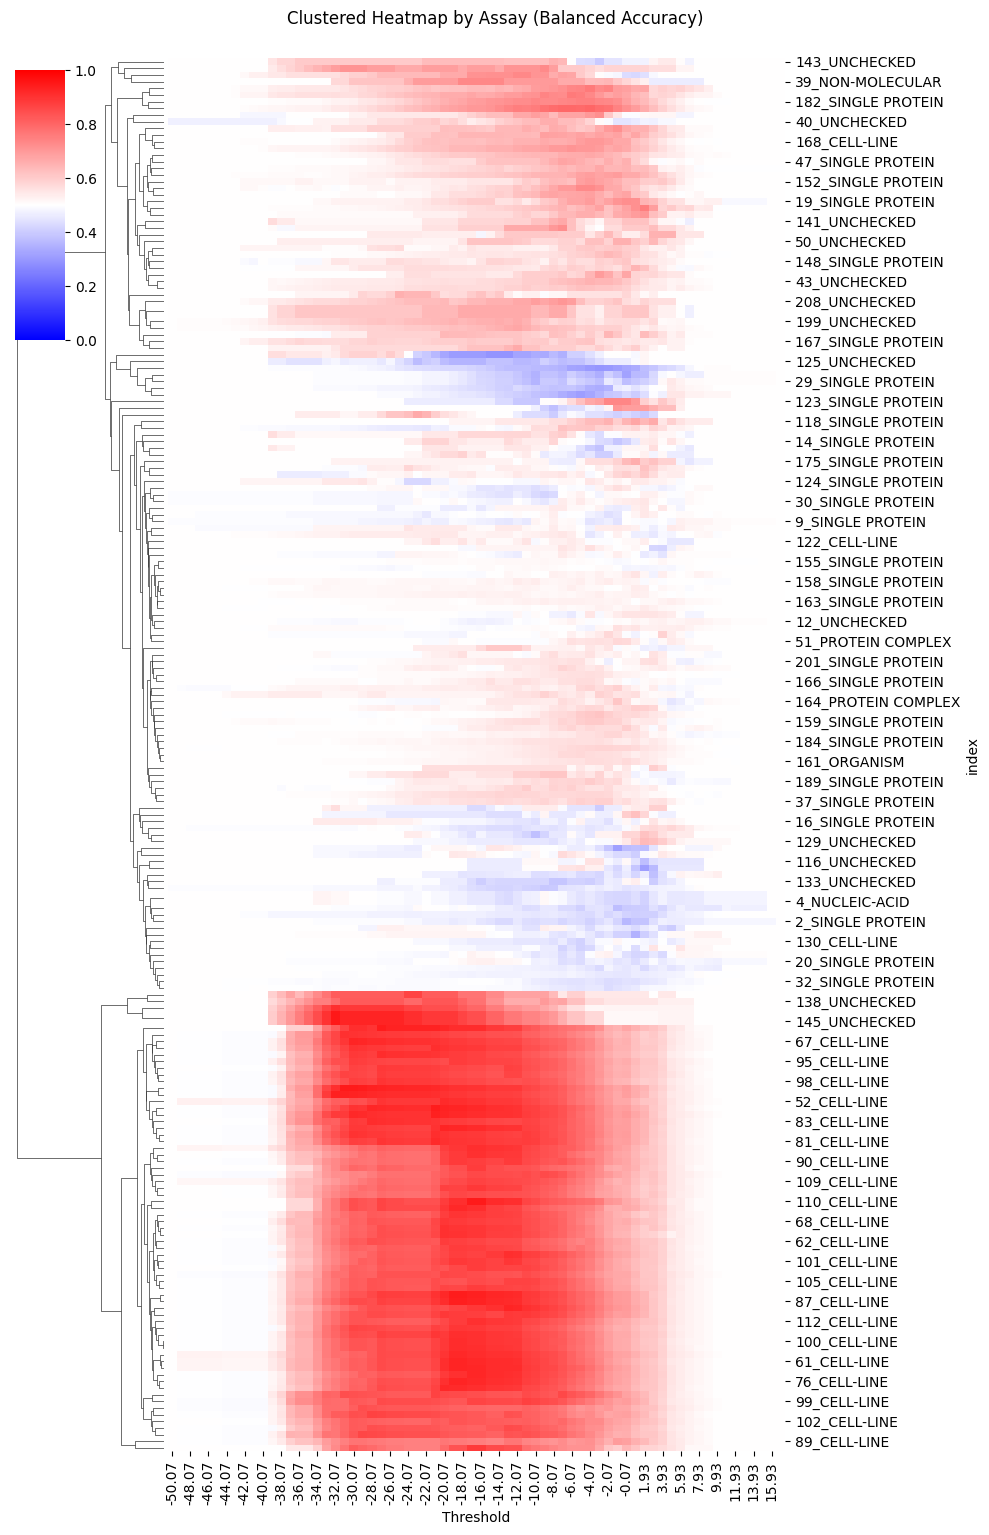

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Create the custom colormap
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'blue'), (0.5, 'white'), (1, 'red')])

# Create a pivot table for the heatmap
heatmap_data = detailed_results_df.pivot(index='index', columns='Threshold', values='Balanced Accuracy')

# Plot the clustered heatmap with improved y-axis labels
cluster_map = sns.clustermap(heatmap_data, cmap=custom_cmap, cbar=True, figsize=(10, 15), 
                             row_cluster=True, col_cluster=False, dendrogram_ratio=(0.2, 0), 
                             method='average', center=0.5, vmin=0, vmax=1)

# Set the title
cluster_map.fig.suptitle('Clustered Heatmap by Assay (Balanced Accuracy)', y=1.02)

# Rotate y-axis labels for better visibility
for label in cluster_map.ax_heatmap.get_yticklabels():
    label.set_rotation(0)  # Horizontal labels

# Show the plot
plt.show()
